# Adaptive PDE discretizations on cartesian grids
## Volume : Reproducible research
## Part : Convergence rates
## Chapter : Eulerian discretizations of the eikonal equation

In this notebook, we check the convergence rate of the HFM eikonal solver, when applied to Eulerian discretizations of eikonal equations, with a point source.
Three cases are considered: Isotropic, Riemannian, and Tilted Transversely Isotropic (TTI) media.
The discussion below is mostly irrelevant for Semi-Lagrangian schemes, which typically enjoy strict causality and are therefore more tolerant to perturbations introduced by the source factorization.

**Takeaway message.** When computing the distance map from a *point source* in a *smooth medium*, using an *Eulerian scheme* for the eikonal equation solve with the *fast marching method*, one can *empirically* achieve a $O(h^{3/2})$ convergence rate error but not more. Note that all the words in italic are essential:
* *Point source.* The distance map w.r.t a point source has a singularity, which is the main source of numerical error. Second order convergence can be achieved if the distance is computed from a smooth set instead of a point, for instance.
* *Smooth medium.* If the domain is equipped with a non-smooth metric, or if obstacles are present, which is the case in many applications, then the contributions discussed below are not anymore the dominant sources of error.
* *Eulerian scheme.* The alternative approach of semi-Lagrangian schemes allows to achieve second order, and even third order convergence rates in these conditions. A number of semi-Lagrangian schemes are implemented in the HFM library, covering the use cases considered below.
* *Fast marching method.* The eulerian schemes implemented in the HFM library, when combined with source factorization, fail the causality property. (Although they are small perturbations of causal schemes.) As a result the FMM cannot solve the scheme exactly, and in principle second order accuracy may be restored if one could exactly solve the numerical scheme exactly. However doing this is non-trivial, even with an iterative method, since the second order schemes also fail the degenerate ellipticity property (stability).
* *Empirical convergence rates.* Our convergence rate estimates are based on an informal analysis, and backed by numerical experiments. However, establishing guarantees on the convergence rate require an entirely different set of mathematical tools, and is usually limited to $O(\sqrt{h})$ (half order convergence rate) which is far below the observed accuracy.

**Semi-Lagrangian vs Eulerian discretizations of the eikonal equation.**
In view of the discussions presented in this notebook, it may seem preferable to favor the use of semi-Lagrangian schemes when high accuracy is needed. In practice, replace `Isotropic2` and `Riemann2` models with the `Rander2` model which generalizes them both and uses a semi-Lagrangian discretization. Similarly, replace the `TTI2` model with the `Hooke2` model which generalizes it and uses a semi-Lagrangian discretization. There are however some reasons to study Eulerian schemes:
- They are easier to implement, especially in three dimensions. In particular there is no `Rander3` model in the HFM library, and the `Hooke3` model is limited in terms of the anisotropy it can handle.
- They are easier to port on the GPU. In particular, the GPU eikonal solver present in the agd library does not apply to the `Hooke` models (semi-lagrangian). It does handle the `Rander2` and `Rander3` models, but based on a different implementation (eulerian) than the HFM library (semi-lagrangian).

See the notebooks [EikonalRate](EikonalRate.ipynb) and [HighAccuracy](../Notebooks_FMM/HighAccuracy.ipynb) for more comparisons of the accuracy of Eulerian vs semi-Lagrangian discretizations of the Eikonal PDE.

**Multigrid techniques.**
Another approach to achieve second order accuracy would involve running the fast marching method twice, first on a fine grid in a neighborhood of the seed, then on the full domain. This technique is a bit technical to put in place, and is not considered here.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Discussion](#1.-Discussion)
    * [1.1 Expected accuracy](#1.1-Expected-accuracy)
    * [1.2 Test case construction](#1.2-Test-case-construction)
  * [2. Isotropic metrics](#2.-Isotropic-metrics)
    * [2.1 Constant medium](#2.1-Constant-medium)
    * [2.2 Smooth medium](#2.2-Smooth-medium)
    * [2.3 Convergence](#2.3-Convergence)
  * [3 Riemannian metrics](#3-Riemannian-metrics)
    * [3.1 Constant medium](#3.1-Constant-medium)
    * [3.2 Smooth medium](#3.2-Smooth-medium)
    * [3.3 Convergence rates](#3.3-Convergence-rates)
  * [4. Tilted transversely isotropic metrics](#4.-Tilted-transversely-isotropic-metrics)
    * [4.1 Constant medium](#4.1-Constant-medium)
    * [4.2 Smooth medium](#4.2-Smooth-medium)
    * [4.3 Convergence rate](#4.3-Convergence-rate)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('EikonalEulerian_Rate','Repro'))

In [2]:
from agd import Metrics
from agd.Metrics import Seismic
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.AutomaticDifferentiation.Optimization import norm as normlp

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HighAccuracy
    [HighAccuracy] = rreload([HighAccuracy],rootdir='../..')

## 0.1 Additional configuration

In [5]:
large_instances = False

In [6]:
dimx2max = 500 if large_instances else 200 
dimx3max = 100 if large_instances else 50
dimxn = 15 if large_instances else 8

In [7]:
dimx2s = np.geomspace(10,dimx2max,dimxn)
dimx3s = np.geomspace(10,dimx3max,dimxn)

## 1. Discussion

We first discuss the expected accuracy of the proposed numerical solver, and then the construction of the test cases.

### 1.1 Expected accuracy

We present an *informal* discussion of the expected accuracy of the fast marching method when solving Eulerian discretizations of Eikonal PDEs.
Let us emphasize that, as soon as the data is non-smooth, or some obstacles are present, which is common in a number of applications, the elements discussed below are not anymore the dominant sources of error.
Note that establishing rigorous estimates for the convergence rate of the eikonal equation requires a different set of techniques than the informal arguments below, and that the best error estimates usually established are $O(h^{\frac 1 2})$.)

**Basic scheme.**
The PDE discretization takes, in the Isotropic and Riemannian case, takes the form
$$
    \sum_{1 \leq i \leq I} \alpha_i \max\{0, u(x)-u(x-h e_i), u(x)-u(x+h e_i)\}^2 = h^2.
$$
For isotropic metrics, one has $I=d$ the domain dimension, unit weights $\alpha_i=1$, and offsets $(e_i)_{i=1}^d$ defined as the canonical basis.
For Riemannian metrics, the weights and offsets are built adaptively. 

The above basic numerical scheme (with suitable boundary conditions) yields a coupled system of non-linear equations on the discretization grid $X_h = \Omega \cap h Z^d$, where $h>0$ is the grid scale and $\Omega$ is the PDE domain. It can be solved in a single pass using the fast marching method thanks to the following properties.
* *Degenerate ellipticity*: the scheme is a *non-decreasing* function of the finite differences $u(x)-u(y)$, $y \in X_h\setminus \{x\}$.
* *Causality*: the scheme only depends on the *positive part* of the finite differences $u(x)-u(y)$, $y \in X_h\setminus \{x\}$.

However, this numerical scheme is not very accurate, since it is only first order, and since it suffers from the singularity of the solution at the source point.

**seed radius.**
On a small neighborhood of the seed point, and in view of the singularity of the solution, it is often preferable to fix the values rather than try to compute them via a numerical scheme. By default, the HFM library defines this region as a disk, whose radius is referred to as the *seed radius*. We distinguish between the absolute seed radius $r$, and the `seedRadius` parameter of the HFM library which is measured in pixels. They are tied by the relation $r = h\times $`seedRadius`.

Over the seed radius, the following approximation of the solution is used:
$$
    u_{\mathrm{ref}}(x) = \frac 1 2 (N_0(x)+N_x(x)),
$$
assuming the seed point located at the origin, and where $N_x$ denotes the metric at $x$.
This approximation is third order accurate
$$
    u_{\mathrm{ref}}(x) - u(x) = O(\|x\|^3).
$$

In *multigrid* techniques the reference solution $u_{\mathrm{ref}}$ is not produced by an analytic expression, but is the result of a numerical computation on a fine grid restricted in a neighborhood of the origin. This approach is somewhat more technical to put in place, but if done correctly should allow to achieve second order accuracy at a reasonable cost.

**Source factored scheme.**
The singularity of the solution at the seed point is the source of substantial numerical error, which can be greatly reduced thanks to a technique known as source factorization. The scheme is replaced with 
$$
    \sum_{1 \leq i \leq I} \alpha_i \max\{0, u(x)-u(x-h e_i)+\rho_i^{+h}, u(x)-u(x+h e_i)+\rho_i^{-h}\}^2 = h^2.
$$
where we denoted 
$$
    \rho_i^{\pm h} := \pm h <\nabla u_*(x),e_i> - \big( u_*(x)-u_*(x\pm h e_i) \big),
$$
and where $u_*$ is a function that has the same singularity as the solution $u$ at the seed point, and that can be efficiently evaluated numerically.
A consistency analysis shows that, if $u_*$ obeys the eikonal equation of interest, then it is the exact solution of the scheme.

The above source factored numerical scheme is *degenerate elliptic*, hence can be solved with the iterative methods such as fast-sweeping, AGSI, FIM (cite your preferred variant) or the GPU-based eikonal solved included in the agd library. 

However the source factored scheme is **not** *causal*, due to the addition of $\rho_i^\pm$ to the finite differences, hence it cannot be solved exactly with the fast marching method. More precisely, issues arise when the scheme solution satisfies $u(x) < u(x-he_i)$ but $u(x)-u(x-h e_i) + \rho_i^{+h} > 0$ (and likewise if $u(x) < u(x+he_i)$ but $u(x)-u(x+h e_i) + \rho_i^{-h} > 0$). Since the successive solution values solved by the Fast Marching Method (FMM) are in increasing order $u(x_0) \leq u(x_1) \leq ...$, the FMM cannot use $u(x-h e_i)$ when solving for $u(x)$, even though the corresponding contribution $u(x)-u(x-h e_i) + \rho_i^{+h}$ is positive (note that it is upper bounded by $\rho_i^{+h}$).

A Taylor expansion, assuming that $u_*$ is smooth except for a singularity at $0$ and is $1$-homogeneous, shows that introduced by the Fast marching method in the situation discussed in the previous paragraph is 
$$
    \rho_i^{\pm h} = O(h^2 / \|x\|).
$$
Such errors accumulate along the geodesic paths, with an overall contribution $O(h |\ln r|)$ to the global error where $r$ is the seed radius.
Balancing the two sources of error
$$
    \mathrm{error}(h,r) = h |\ln r| + r^3
$$
suggests that $r = \sqrt[3]{h}$ is optimal (up to constant factors). Note however that the simpler choice $r=O(h)$ yields a comparable overall error $O(h |\ln h|)$.

**Second order scheme.**
In order to achieve even greater accuracy, second order finite differences may be introduced in the scheme. They are obtained with the second order correction
$$
    \big(u(x)-u(x-h e_i)\big) + \frac 1 2 \big(u(x)-2 u(x-he_i)+u(x-2 h e_i)\big),
$$
and the source factorization correction
$$
    \rho_i^{+ h} := h <\nabla u_*(x),e_i> - \big(u_*(x)-u_*(x- h e_i)\big) - \frac 1 2 \big(u_*(x)-2 u_*(x-he_i)+u_*(x-2 h e_i)\big),
$$
and likewise for $\rho_i^{-h}$ and the other sided finite difference.

Due to the finite differences modification, the numerical scheme looses the *degenerate ellipticity* property, in other words all stability. As a result it cannot be solved as-is by either the fast marching method or an iterative method. Instead the second order correction is activated or deactivated depending on the local behavior of the solution as it is solved, which is easiest done with the FMM. There is no theoretical guarantee that second order convergence is achieved, but the method is empirically not useless. 

Because causality is lost, the strict ordering $u(x_0) \leq u(x_1) \leq ...$ of the FMM local solves introduces as before errors of magnitude $\rho_i^{\pm h}$. A Taylor expansion yields
$$
    \rho_i^{\pm h} = O(h^3 / \|x\|^2).
$$
Again such errors accumulate along the geodesic paths, with an overall contribution $O(h^2/r)$ to the global error where $r$ is the seed radius. 

Balancing the two contributions, we find that the overall error
$$
    \mathrm{error}(h,r) = \frac{h^2} r + r^3
$$
attains its minimum $\approx h^\frac 3 2$ for $r = \sqrt h$, up to constant factors. This falls short of second order accuracy.

**Envelope of schemes.**
The Tilted transversely isotropic scheme takes the form 
$$
    \max_{t \in [0,1]} 
    \sum_{1 \leq i \leq I} \alpha_i^t \max\{0, u(x)-u(x-h e_i^t), u(x)-u(x+h e_i^t)\}^2 = h^2.
$$
(with possibly the max replaced with a $\min$). In this form, the scheme is degenerate elliptic and causal. The previously discussed modifications related to source factorization and second order finite differences are applicable, but the focus of this paragraph is on the dependency w.r.t the parameter $t\in [0,1]$.


There are two approaches to implementing the optimization over $t \in [0,1]$
* *Finite sampling.* 
Introduce $K$ equispaced points in the interval, namely $t_k = k/(K-1)$, $0 \leq k \leq K$, and optimize over those. A systematic error is introduced in the solution, which is $O(1/K^2)$ overall under standard assumptions.
* *Full optimization.*
Note that this may sound like an overcomplicated approach, but is does work in practice.
For the model of interest, one can show that the interval $[0,1]$ can be split in finitely many sub-intervals with endpoints $0 = t_0 < t_1 \cdots < t_N = 1$, where the coefficients $t \mapsto \alpha_i^t$ are smooth and the offsets $t \mapsto e_i^t$ are constant. Furthermore one can show that the scheme numerical expression has *no spurious extrema* in $[t_i,t_{i+1}]$, $0 \leq i < N$. Thus one can optimize over $t \in [0,1]$ up to machine precision using e.g. golden search (in the proposed implementation a mixture of golden search and of a Newton method).

The two approaches are implemented, and can be selected when calling the HFM library. On the CPU *finite sampling* approach was mostly intended for debugging purposes, and the *full optimization* is the default. On the GPU, concerns about thread divergence led us to implement the *finite sampling* approach only.

### 1.2 Test case construction

Our test case is obtained by applying a diffeomorphism to a domain equipped with a constant metric.
The chosen diffeomorphism is known as a *special conformal transformation*, meaning that is preserves angles locally, allowing to use it in the isotropic case as well. The following test case also applies in dimension three, with minor modifications.

In [8]:
def SPCT(x,b):
    """Special conformal transformation, with singularity at b/|b|^2"""
    b = fd.as_field(b,x.shape[1:])
    x2,xb,b2 = [lp.dot_VV(a,b) for a,b in [(x,x),(x,b),(b,b)]]
    return (x-x2*b)/(1-2*xb+x2*b2)

ϕ = lambda x : SPCT(x,[0.1,0.2]) # Our diffomorphism

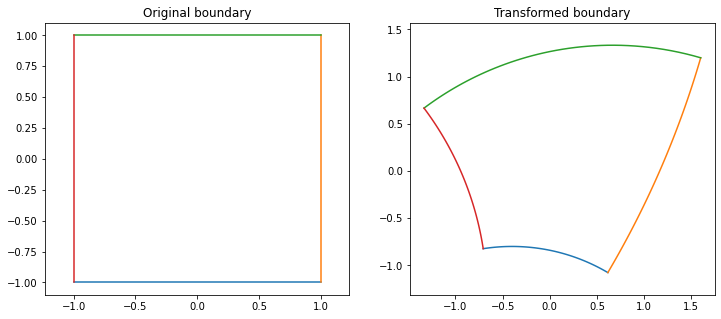

In [9]:
aX = np.linspace(-1,1,endpoint=True)
X = ad.array(np.meshgrid(aX,aX,indexing='ij'))

boundary = np.stack( [X[:,:,0],X[:,-1,:],X[:,::-1,-1],X[:,0,::-1]] ,axis=-1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Original boundary')
plt.plot(*boundary)

plt.subplot(1,2,2); plt.axis('equal'); plt.title('Transformed boundary')
plt.plot(*ϕ(boundary));

In [10]:
def test_accuracy(dimx,norm,ϕ=None,seedpx=None,boundarypx=None,traits=None):
    """
    Test the accuracy of the HFM library on a synthetic problem in [-1,1]^d
    Inputs : 
        - dimx. Dimension of the domain, along any axis.
        - norm. A single norm.
        - ϕ. A diffeomorphism of the domain.
        - seedpx. Seed position, from center, in pixels.
        - boundarypx. Points to be ignored on the boundary when computing error, in pixels.
        - traits. Additional input to the HFM library.
    """
    vdim=norm.vdim
    hfmIn = Eikonal.dictIn({
        'model':norm.model_HFM(),
        'exportValues':True,
        'verbosity':0,
        'seedRadius':np.sqrt(dimx/2), # Spread seed values, over optimal radius r=sqrt(h)
        'factoringRadius':-1, # Factorization over the whole domain
        'order':2, # second order scheme
    })
    if traits is not None: hfmIn.update(traits)
    hfmIn.SetRect(([-1,1],)*vdim,dimx=dimx,sampleBoundary=True)
    h = hfmIn['gridScale']
    if seedpx is None: hfmIn['seed'] = (0,)*vdim
    else: hfmIn['seed'] = ad.array(seedpx)*h
    
    if ϕ is None: ϕ = lambda x : x # Identity diffeomorphism by default.
    X = hfmIn.Grid()
    seed = fd.as_field(hfmIn['seed'],hfmIn.shape)
    exact_solution = norm.norm(ϕ(X)-ϕ(seed))
    
    X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
    Jacϕ = ϕ(X_ad).gradient().swapaxes(0,1)
    if isinstance(norm,Metrics.Isotropic) or isinstance(norm,Seismic.Hooke): 
        # Assuming a conformal mapping, otherwise inconsistent
        α = normlp(Jacϕ,axis=(0,1),ord=2)/np.sqrt(vdim) # Scaling
        R = Jacϕ/α # Rotation
        hfmIn['metric'] = norm.with_cost(α).rotate(lp.transpose(R))
    else: hfmIn['metric'] = norm.inv_transform(Jacϕ)
    
    hfmOut = hfmIn.Run()
    
    error = exact_solution - hfmOut['values'] #Optionally erase error on boundary 
    if boundarypx is not None: error[normlp(X,ord=np.inf,axis=0)>=1-boundarypx*h]=0 
        
    return normlp(error,ord=1,averaged=True),normlp(error,ord=np.inf),error,hfmIn, hfmOut

## 2. Isotropic metrics

Isotropic metrics are locally proportionnal to the Euclidean metric. Isotropic fast marching dates back to the works of Rouy (1992), Tsitsilikis (1995), and Sethian (1996).

In [11]:
norm = Metrics.Isotropic(1,vdim=2)

### 2.1 Constant medium

When the metric is constant, source factorization is activated, and the seed is in the discretization grid, the solution can be reproduced exactly.

In [12]:
assert test_accuracy(101,norm)[1] < 1e-13 # Exact reproduction, order 2 with source factorization
assert test_accuracy(101,norm,traits={'order':1})[1] < 1e-13 # Exact reproduction, order 1 with source factorization

However this only happens *by chance*, and exact reproduction is lost as soon as the seed point is not a grid point. This is because the scheme is non-causal, and the FMM only solves it approximately. An iterative scheme would yield exact reproduction. The error is small nonetheless.

In [13]:
_,error_linf_cst,error,hfmIn,_ = test_accuracy(100,norm)
assert error_linf_cst<3e-4 # Very small but non-vanishing error, because scheme is not exactly solver

Numerical error is largest along the axes.

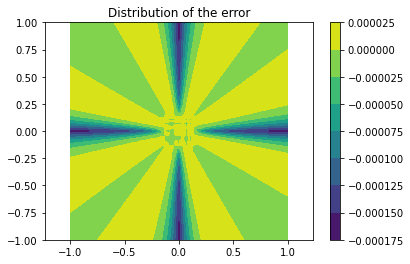

In [14]:
plt.title('Distribution of the error'); plt.axis('equal')
plt.contourf(*hfmIn.Grid(),error); plt.colorbar();

If source factorization is not activated, then the numerical error is an order of magnitude larger. 

In [15]:
_,error_linf_nofact,_,_,_ = test_accuracy(100,norm,traits={'factoringRadius':0})

In [16]:
error_linf_nofact/error_linf_cst

9.807655242731178

### 2.2 Smooth medium

If the medium is not smooth, then the exact solution is not reproduced exactly by the numerical scheme, as could be expected

In [17]:
_,error_linf,error,hfmIn,hfmOut = test_accuracy(100,norm,ϕ=ϕ)
print("Linfty error : ",error_linf)
assert error_linf < 3e-4

Linfty error :  0.00016827677391084706


Recall that the metric in the domain $[-1,1]^2$ is obtained as the pull back of a constant metric in via the diffeomorphism $\phi$.
In the transformed domain, the solution is thus the Euclidean norm.

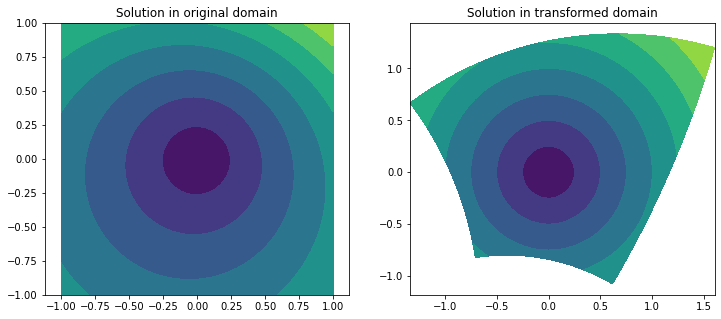

In [18]:
X = hfmIn.Grid()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.axis('equal'); plt.title("Solution in original domain")
plt.contourf(*X,hfmOut['values'])

plt.subplot(1,2,2); plt.axis('equal'); plt.title("Solution in transformed domain")
plt.contourf(*ϕ(X),hfmOut['values']);

The optimal choice of `seedRadius` reflects a compromise between several types of errors. For the second order scheme, an educated guess is to use the absolute seed radius $r=\sqrt h$ where $h$ is the grid scale. For the first order scheme, $r=\sqrt[3]{h}$ would be optimal, but we do not expect much sensitivity since $r=2h$ yields a similar convergence rate. Recall that the corresponding parameter of the HFM library is measured in pixels, in other words $r = h\times $`seedRadius`.

In [19]:
h = hfmIn['gridScale']
print("Second order, suggested seedRadius, in pixels ", np.sqrt(h)/h)
print("First order, suggested seedRadius, in pixels ", np.power(h,1/3)/h)

Second order, suggested seedRadius, in pixels  7.035623639735144
First order, suggested seedRadius, in pixels  13.481456020613523


Numerical experiments confirm that the scaling $r=\sqrt h$ is appropriate for the second order scheme, since or larger values yield larger errors in this example.

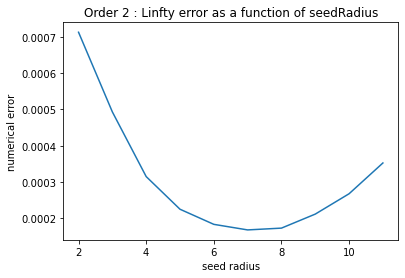

In [20]:
plt.title("Order 2 : Linfty error as a function of seedRadius")

seedRadii = range(2,12)
errors_linf_seedRadii = [test_accuracy(100,norm,ϕ=ϕ,traits={'seedRadius':seedRadius})[1] for seedRadius in seedRadii]

plt.plot(seedRadii,errors_linf_seedRadii)
plt.xlabel("seed radius")
plt.ylabel("numerical error");

In the first order case, or educated guess $r=\sqrt[3]{h}$ is again optimal, but the sensitivity to this parameter is very small, just as we expected.

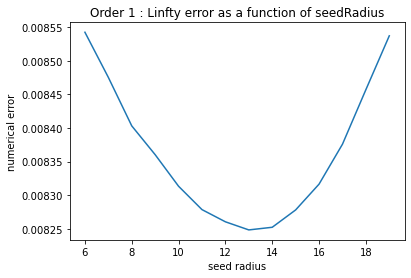

In [21]:
plt.title("Order 1 : Linfty error as a function of seedRadius")

seedRadii = range(6,20)
errors_linf_seedRadii = [test_accuracy(100,norm,ϕ=ϕ,traits={'seedRadius':seedRadius,'order':1})[1] for seedRadius in seedRadii]

plt.plot(seedRadii,errors_linf_seedRadii)
plt.xlabel("seed radius")
plt.ylabel("numerical error");

### 2.3 Convergence

We expect the convergence rate $O(h^{-3/2})$ for the scheme equipped with second order finite differences, and using the suggested seed radius $r = \sqrt h$. This is confirmed by numerical experiments.

In [22]:
errors = [test_accuracy(dimx,norm,ϕ=ϕ)[:2] for dimx in dimx2s]

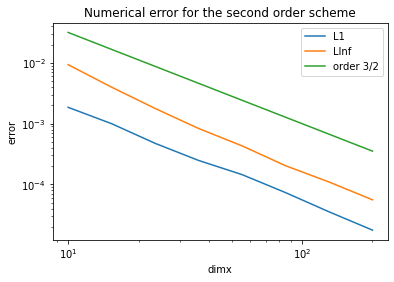

In [23]:
plt.title("Numerical error for the second order scheme"); plt.xlabel("dimx"); plt.ylabel("error")
plt.loglog(dimx2s,errors)
plt.loglog(dimx2s,dimx2s**-(3/2))
plt.legend(("L1","LInf","order 3/2")); # Alternative caption : r"$L^\infty$"

When using a seed radius $r=O(h)$, in otherwords a fixed `seedRadius` parameter, the convergence rate appears to be $h^2$ for large grid scales, but this convergence rate is not maintained at small grid scales. This is expected from our formal accuracy analysis.

In [24]:
errors_fixed_seedRadius = [test_accuracy(dimx,norm,ϕ=ϕ,traits={'seedRadius':3})[:2] for dimx in dimx2s]

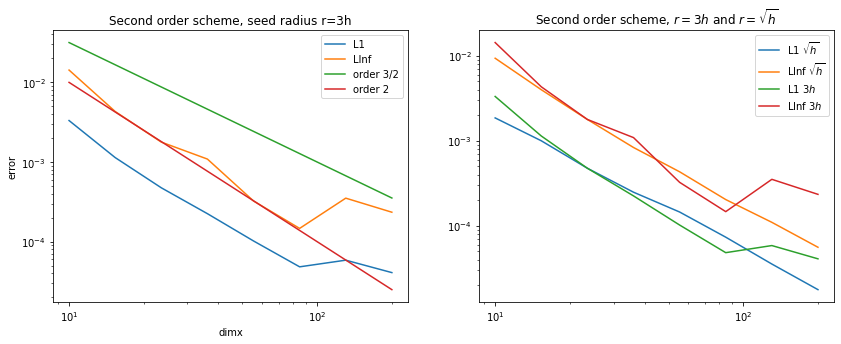

In [25]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.title("Second order scheme, seed radius r=3h")
plt.loglog(dimx2s,errors_fixed_seedRadius)
plt.loglog(dimx2s,dimx2s**-(3/2))
plt.loglog(dimx2s,dimx2s**-2)
plt.legend(("L1","LInf","order 3/2","order 2")); plt.xlabel("dimx"); plt.ylabel("error")

plt.subplot(1,2,2)
plt.title(r"Second order scheme, $r=3h$ and $r=\sqrt{h}$")
plt.loglog(dimx2s,errors)
plt.loglog(dimx2s,errors_fixed_seedRadius)
plt.legend((r"L1 $\sqrt{h}$",r"LInf $\sqrt{h}$", r"L1 $3h$", r"LInf $3h$"));

We expect the convergence rate $O(h |\ln h|)$ for the scheme equipped with first order finite differences, and using either the (supposedly optimal) large seed radius $r=\sqrt[3]{h}$ or the small radius $r=2h$.

Numerical experiments confirm the expected convergence rate, and show extremely small sensitivity to the value of $r$. 

In [26]:
errors_largeRadius = [test_accuracy(dimx,norm,ϕ=ϕ,traits={'order':1,'seedRadius':np.power(dimx/2,1/3)})[:2] for dimx in dimx2s]
errors_smallRadius = [test_accuracy(dimx,norm,ϕ=ϕ,traits={'order':1,'seedRadius':2})[:2] for dimx in dimx2s]

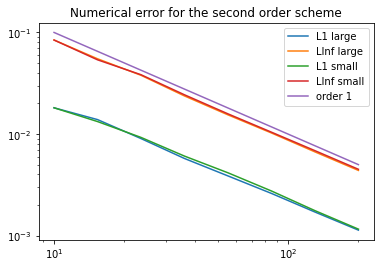

In [27]:
plt.title("Numerical error for the second order scheme")
plt.loglog(dimx2s,errors_largeRadius)
plt.loglog(dimx2s,errors_smallRadius)
plt.loglog(dimx2s,dimx2s**-1)
plt.legend(("L1 large","LInf large","L1 small","LInf small","order 1")); 

## 3 Riemannian metrics

We reproduce similar experiments, but now introducing some elliptic anisotropy. (We use a modest anisotropy ratio here, in order to illustrate high accuracy, although the HFM handles much more pronounced anisotropies.)

In [28]:
norm = Metrics.Riemann.from_diagonal((1,1/4)).rotate_by(np.pi/3)

### 3.1 Constant medium

Even in a constant medium, and with a seed located on a grid point, the exact solution is not exactly reconstructed. That is because the FMM cannot solve the scheme exactly due to the loss of causality. 

In [29]:
_,error_linf,error,hfmIn,hfmOut = test_accuracy(101,norm,boundarypx=4)
print("LInf error : ",error_linf)
assert error_linf<1e-4

LInf error :  3.4635347030520514e-05


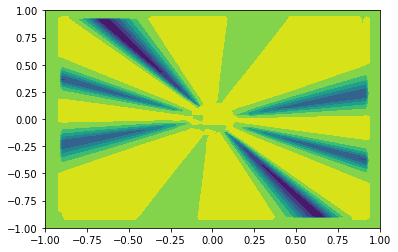

In [30]:
X = hfmIn.Grid()
plt.contourf(*X,error);

Note that, in contrast, the FMM produces the exact solution when using a semi-lagrangian scheme (which is strictly causal).

In [31]:
error_linf_semiLagrangian = test_accuracy(101,norm,boundarypx=4,traits={'model':'Rander2'})[1]
assert error_linf_semiLagrangian<1e-12

### 3.2 Smooth medium

The anisotropy direction of the Riemannian metric varies over the domain, and the structure of the scheme - weights and offsets - varies from point to point.

In [32]:
_,error_linf,error,hfmIn,hfmOut = test_accuracy(100,norm,ϕ=ϕ,boundarypx=4)
print("Linfty error : ",error_linf)
assert error_linf < 3e-4

Linfty error :  0.0001802071486678436


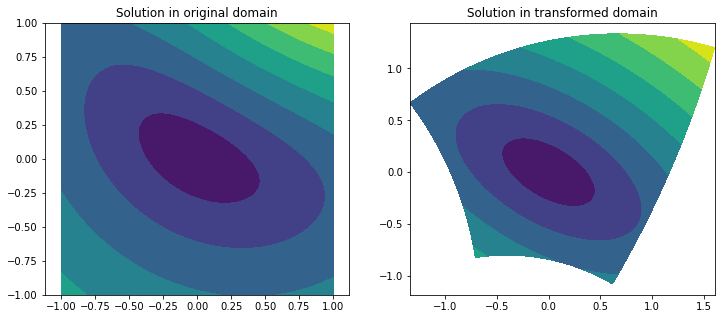

In [33]:
X = hfmIn.Grid()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.axis('equal'); plt.title("Solution in original domain")
plt.contourf(*X,hfmOut['values'])

plt.subplot(1,2,2); plt.axis('equal'); plt.title("Solution in transformed domain")
plt.contourf(*ϕ(X),hfmOut['values']);

For the second order scheme, a seed radius $r=\sqrt h$, here $7$ pixels, is again optimal just as our educated guess predicted.

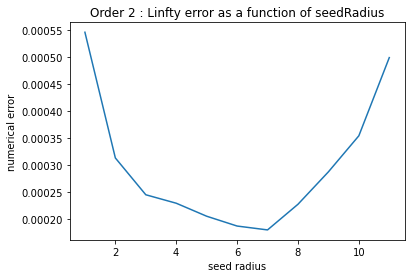

In [34]:
plt.title("Order 2 : Linfty error as a function of seedRadius")

seedRadii = range(1,12)
errors_linf_seedRadii = [test_accuracy(100,norm,ϕ=ϕ,boundarypx=4,traits={'seedRadius':seedRadius})[1] for seedRadius in seedRadii]

plt.plot(seedRadii,errors_linf_seedRadii)
plt.xlabel("seed radius")
plt.ylabel("numerical error");

For the first order scheme, our educated guess $r=\sqrt[3]{h}$, here $13.5$ pixels, is not precisely optimal but it is a safe value.
(Note that the numerical error is here rather insensitive to the `seedRadius` parameter, unless it is too large, so using $r=2h$ could be an even safer choice.) 

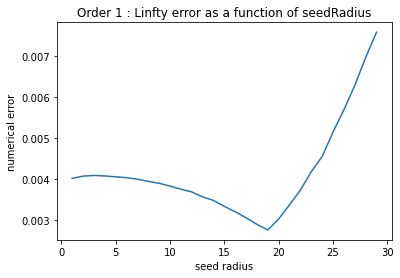

In [35]:
plt.title("Order 1 : Linfty error as a function of seedRadius")

seedRadii = range(1,30)
errors_linf_seedRadii = [test_accuracy(100,norm,ϕ=ϕ,boundarypx=4,traits={'seedRadius':seedRadius,'order':1})[1] for seedRadius in seedRadii]

plt.plot(seedRadii,errors_linf_seedRadii)
plt.xlabel("seed radius")
plt.ylabel("numerical error");

### 3.3 Convergence rates

We observe the expected order $h^{3/2}$ convergence rate, when using the second order scheme with source factorization. Note that a thin boundary layer of `boundarypx` pixels is excluded from the error estimate.

In [36]:
dimx2s_ = dimx2s[2:] # Excluding excessively small resolutions (because boundary layer is excluded from error)
errors = [test_accuracy(dimx,norm,ϕ=ϕ,boundarypx=4)[:2] for dimx in dimx2s_]

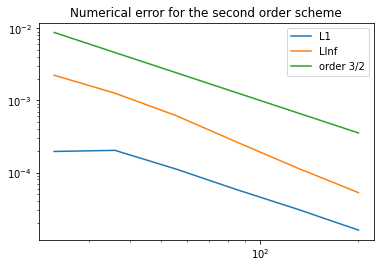

In [37]:
plt.title("Numerical error for the second order scheme")
plt.loglog(dimx2s_,errors)
plt.loglog(dimx2s_,dimx2s_**-(3/2))
plt.legend(("L1","LInf","order 3/2")); 

The expected convergence rate is $O(h |\ln h|)$ with the first order scheme and source factorization. The numerical experiments seem to confirm it,  but are not totall conclusive here.

In [38]:
errors = [test_accuracy(dimx,norm,ϕ=ϕ,boundarypx=3,traits={'order':1,'seedRadius':2})[:2] for dimx in dimx2s_]

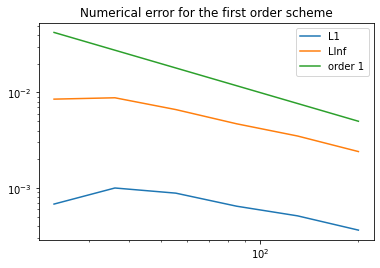

In [39]:
plt.title("Numerical error for the first order scheme")
plt.loglog(dimx2s_,errors)
plt.loglog(dimx2s_,dimx2s_**-1)
plt.legend(("L1","LInf","order 1")); 

## 4. Tilted transversely isotropic metrics

Tilted transversely isotropic media are defined by a special kind of Finslerian metrics, whose unit ball locally can be described as the envelope of a one dimensional family of ellipses. The number of ellipses used in the numerical scheme can be controlled by the parameter `nmix` of the HFM library : 0 for an infinity of ellipses (default, based on countinuous optimization), or a positive value for a finite number of them.

In [40]:
norm = Seismic.TTI.mica[0].extract_xz().rotate_by(np.pi/3)

### 4.1 Constant medium

Similarly to the Riemannian case, the exact solution is not reproduced exactly due to the lack of causality of the scheme combined with the use of a fast marching method. The numerical error is quite small nevertheless.

In [41]:
_,error_linf,error,hfmIn,hfmOut = test_accuracy(101,norm,boundarypx=4)
print("LInf error : ",error_linf)
assert error_linf<1e-6

LInf error :  4.158346901539378e-07


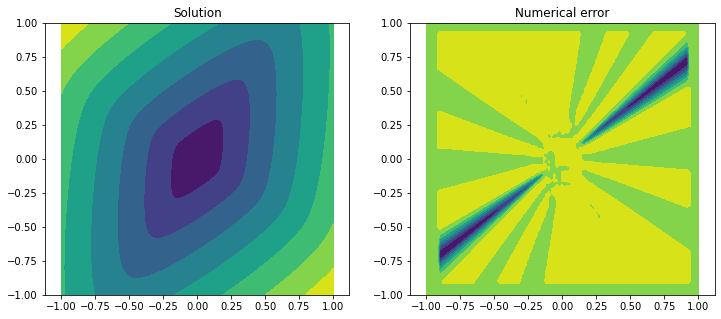

In [42]:
X = hfmIn.Grid()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title('Solution'); plt.axis('equal'); 
plt.contourf(*X,hfmOut['values']);

plt.subplot(1,2,2); plt.title('Numerical error'); plt.axis('equal'); 
plt.contourf(*X,error);

Using a semi-Lagrangian scheme, which enjoys a strict causality property, allows the FMM to reproduce the solution exactly in a constant medium.

In [43]:
norm_hooke = Seismic.Hooke.mica[0].extract_xz().rotate_by(np.pi/3)
_,error_linf_semiLagrangian,error,hfmIn,hfmOut = test_accuracy(101,norm_hooke,boundarypx=4)
print("LInf error : ",error_linf_semiLagrangian)
assert error_linf_semiLagrangian<1e-12

LInf error :  3.0156432906380815e-14


The Finslerian anisotropy of the norm is better approximated as as the number `nmix` of ellipses used increases. (Special value $0$ yields an infinity of ellipses.)

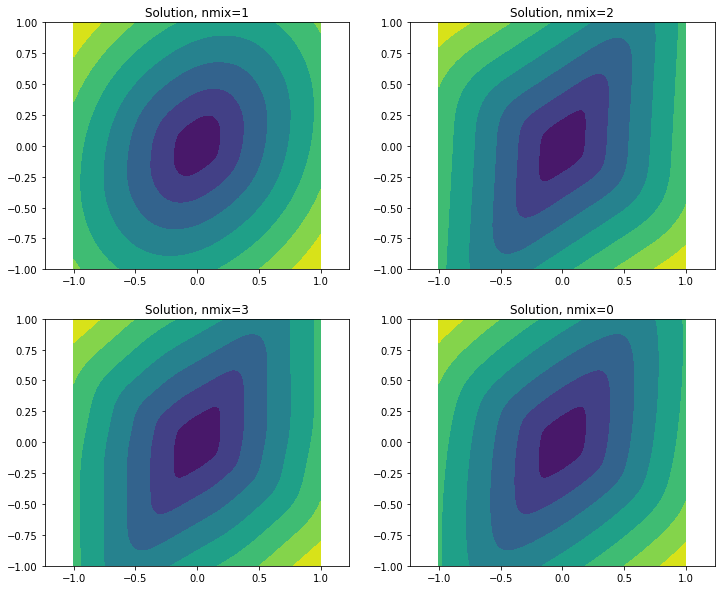

In [44]:
plt.figure(figsize=(12,10))
for i,nmix in enumerate([1,2,3,0]):
    plt.subplot(2,2,1+i); plt.title(f'Solution, nmix={nmix}'); plt.axis('equal'); 
    _,_,_,_,hfmOut = test_accuracy(101,norm,boundarypx=4,traits={'nmix':nmix})
    plt.contourf(*X,hfmOut['values']);

### 4.2 Smooth medium

In [45]:
_,error_linf,error,hfmIn,hfmOut = test_accuracy(101,norm,boundarypx=4)
print("LInf error : ",error_linf)
assert error_linf<1e-6

LInf error :  4.158346901539378e-07


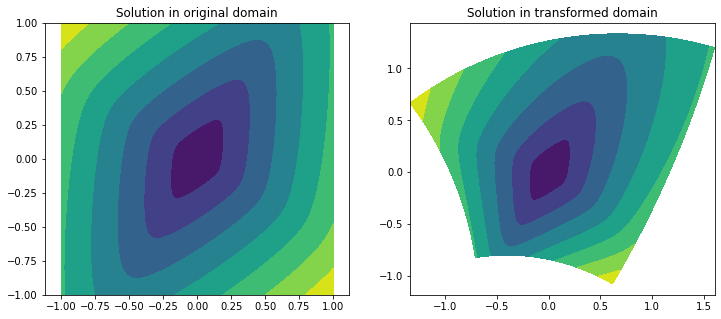

In [46]:
X = hfmIn.Grid()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.axis('equal'); plt.title("Solution in original domain")
plt.contourf(*X,hfmOut['values'])

plt.subplot(1,2,2); plt.axis('equal'); plt.title("Solution in transformed domain")
plt.contourf(*ϕ(X),hfmOut['values']);

In this case, our educated guess $r = \sqrt h$ for the seed radius, a.k.a `seedRadius`$=7$ pixels, is slightly below the optimal value. 

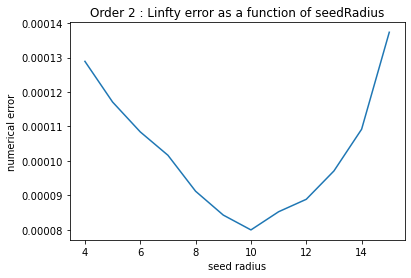

In [47]:
plt.title("Order 2 : Linfty error as a function of seedRadius")

seedRadii = range(4,16)
errors_linf_seedRadii = [test_accuracy(100,norm,ϕ=ϕ,boundarypx=4,traits={'seedRadius':seedRadius})[1] for seedRadius in seedRadii]

plt.plot(seedRadii,errors_linf_seedRadii)
plt.xlabel("seed radius")
plt.ylabel("numerical error");

Another parameter of interest is `nmix`. It is optimal to leave it to the $0$, but one may nevertheless explore how the number of ellipses impacts the numerical error. 

Let us make an educated guess: as discussed above, the numerical error due to the scheme and its FMM resolution scales like $h^{3/2}$, whereas the numerical error due to the number of ellipses scales like $\mathrm{nmix}^{-2}$. An adequate value of `nmix` equates both sources of error, which happens for $\mathrm{nmix} = h^{-3/4}$. Larger values of `nmix` are expected to be essentially useless (error related with `nmix` is not dominant anymore), whereas smaller values substantially increase the overall error.

In [48]:
print("Educated guess of the cutoff value for `nmix`:", hfmIn['gridScale']**(-3/4))

Educated guess of the cutoff value for `nmix`: 18.80301546543197


The educated guess is surprisingly accurate, as illustrated by the following experiment.

In [49]:
nmixs = np.geomspace(1,500,10).astype(int)
errors_linf_nmix = [test_accuracy(100,norm,ϕ=ϕ,boundarypx=4,traits={'nmix':nmix})[1] for nmix in nmixs]

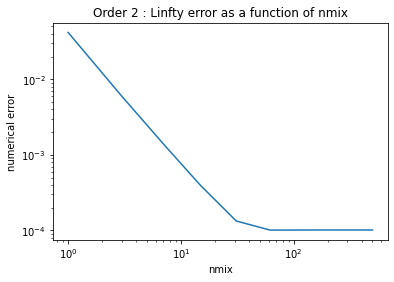

In [50]:
plt.title("Order 2 : Linfty error as a function of nmix")
plt.loglog(nmixs,errors_linf_nmix)
plt.xlabel("nmix")
plt.ylabel("numerical error");

### 4.3 Convergence rate

The expected convergence rate $h^{3/2}$ is attained with the second order scheme, and `nmix`$=0$.

In [51]:
dimx2s_ = dimx2s[2:] # Excluding excessively small resolutions (because boundary layer is excluded from error)
errors = [test_accuracy(dimx,norm,ϕ=ϕ,boundarypx=4)[:2] for dimx in dimx2s_]

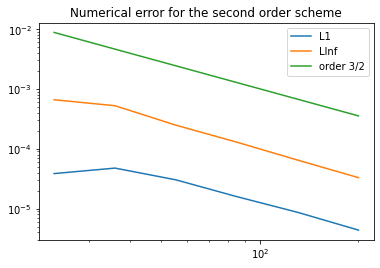

In [52]:
plt.title("Numerical error for the second order scheme")
plt.loglog(dimx2s_,errors)
plt.loglog(dimx2s_,dimx2s_**-(3/2))
plt.legend(("L1","LInf","order 3/2")); 

Obviously using a fixed value of `nmix`, independetly of the grid scale, causes the error to stabilize beyond a certain gridscale $h$. (This is especially visible for the $L^\infty$ error.)

In [53]:
dimx2s_ = dimx2s[2:] # Excluding excessively small resolutions (because boundary layer is excluded from error)
errors = [test_accuracy(dimx,norm,ϕ=ϕ,boundarypx=4,traits={'nmix':30})[:2] for dimx in dimx2s_]

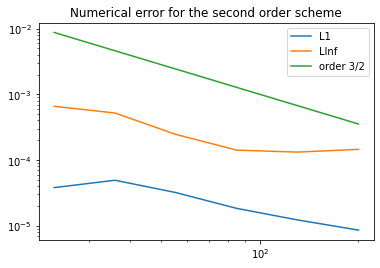

In [54]:
plt.title("Numerical error for the second order scheme")
plt.loglog(dimx2s_,errors)
plt.loglog(dimx2s_,dimx2s_**-(3/2))
plt.legend(("L1","LInf","order 3/2")); 

The first order scheme converges at first order, as expected.

In [55]:
errors = [test_accuracy(dimx,norm,ϕ=ϕ,boundarypx=3,traits={'order':1,'seedRadius':2})[:2] for dimx in dimx2s_]

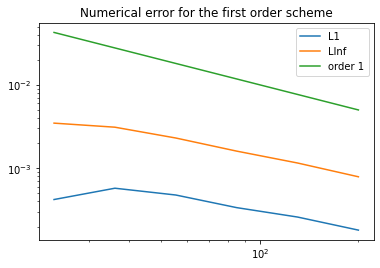

In [56]:
plt.title("Numerical error for the first order scheme")
plt.loglog(dimx2s_,errors)
plt.loglog(dimx2s_,dimx2s_**-1)
plt.legend(("L1","LInf","order 1")); 